# Brain Tumor Classification using Deep Learning

The following notebook will perform brain tumor classification using Deep Learning. Our objective is to use a [Kaggle](https://www.kaggle.com/masoudnickparvar/brain-tumor-mri-dataset) dataset consisting of 7022 brain scans of which includes brains with giloma tumor, meningioma tumor, pituitary tumor and healthy brains. 

<img src="https://www.stlukeshealth.org/content/dam/stlukeshealth/images/brain-cancer-banner.png" align="left" />

In [1]:
import numpy as np
import cv2, os, glob, random
import matplotlib.pyplot as plt
import elasticdeform

## Data exploration

Before jumping into writing models or makingg any statistical assesment, it is important that we study and understand the data we have. Let's plot some graphs and explore some numbers.

#### Place file paths in dictionary

In [2]:
training_images_paths = {}
testing_images_paths = {}

def add_img(d, imgType, imgPath):
    if imgType not in d:
        d[imgType] = [imgPath]
    else:
        d[imgType].append(imgPath)

for trainingImgPath in glob.glob("data/Training/*"):
    imgType = trainingImgPath.split("/")[-1]
    for img in glob.glob(f"data/Training/{imgType}/*"):
        add_img(training_images_paths, imgType, img)
        
for testingImgPath in glob.glob("data/Testing/*"):
    imgType = testingImgPath.split("/")[-1]
    for img in glob.glob(f"data/Testing/{imgType}/*"):
        add_img(testing_images_paths, imgType, img)

#### Plot training and test images quantity vs tumor type

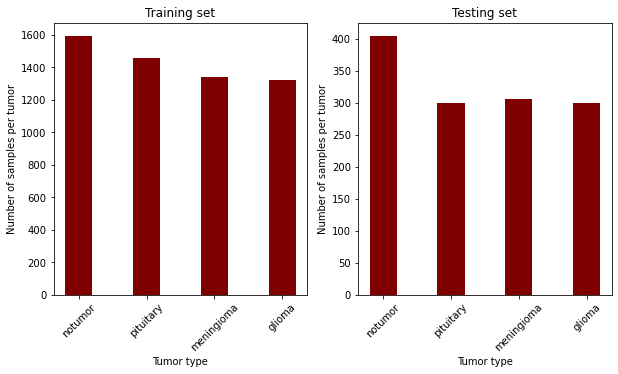

In [3]:
tumors = list(training_images_paths.keys())
tumorTrainingLength =  []
tumorTestingLength =  []

for tumorType in tumors:
    tumorTrainingLength.append(len(training_images_paths[tumorType]))
    tumorTestingLength.append(len(testing_images_paths[tumorType]))

fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.subplot(1,2,1)
plt.bar(tumors, tumorTrainingLength, color ='maroon',
        width = 0.4)
 
plt.xlabel("Tumor type")
plt.ylabel("Number of samples per tumor")
plt.title("Training set")
plt.xticks(rotation=45)

plt.subplot(1,2,2)
plt.bar(tumors, tumorTestingLength, color ='maroon',
        width = 0.4)
 
plt.xlabel("Tumor type")
plt.ylabel("Number of samples per tumor")
plt.title("Testing set")
plt.xticks(rotation=45)

plt.show()

The dataset are well balanced in both training and testing sets.

#### Data observation
Let's observe some brain scans of different types of brain tumors.

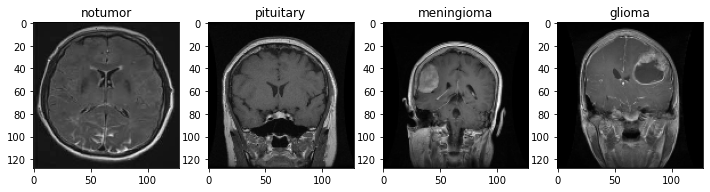

In [4]:
plt.figure(figsize = (12, 5))
for index, tumor in enumerate(tumors):
    imgPath = training_images_paths[tumor][random.randint(1,len(training_images_paths[tumor]))]
    img = cv2.imread(imgPath, 0)
    img = cv2.resize(img, (128,128))
    img = np.array(img)/128
    plt.subplot(1,4,(index+1))
    plt.title(tumor)
    plt.imshow(img, cmap='gray')

## Data transformation

Now that we are more familiar with the data, let's start thinking of transformations we can apply. We will start off by performing basic operations such as data loaders, label encoder and decoder. From there, we will apply transformations on the MRI scans and finally normalize the data.

#### Place training and testing paths in lists

In [5]:
from itertools import chain

train_paths = list(chain.from_iterable(training_images_paths.values()))
test_paths = list(chain.from_iterable(testing_images_paths.values()))

random.shuffle(train_paths)
random.shuffle(test_paths)

#### Useful functions to prepare and transform our data

In [54]:
def transform_images(img, IMAGE_SIZE=128):
    # Power gamma enhance
    randGammaValue = random.uniform(0.4, 0.8)
    gammaImg = np.array(IMAGE_SIZE*(img / IMAGE_SIZE) ** randGammaValue, dtype = 'uint8')
    
    # Elastic transform
    elasticDeformedImg = elasticdeform.deform_random_grid(gammaImg, sigma=2.5, points=3)
    
    return elasticDeformedImg
    
def get_images(img_paths, IMAGE_SIZE=128):
    '''
    Returns a list of images in the form of an np array. Additionally, you can define an image size.
    '''
    images = []
    for path in img_paths:
        img = cv2.imread(path, 0)
        img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
        img = transform_images(img)
        images.append(img)
    return np.array(images)

def encode_label(img_paths):
    '''
    Encode tumors into integers
    0 -> notumor
    1 -> pituitary
    2 -> meningioma
    3 -> glioma
    '''
    labels = []
    for path in img_paths:
        label = path.split("/")[2]
        if label == "notumor":
            labels.append(0)
        elif label == "pituitary":
            labels.append(1)
        elif label == "meningioma":
            labels.append(2)
        else:
            labels.append(3)
            
    return np.array(labels)

def decode_label(labels):
    '''
    Decode labels according to legend listed above
    '''
    tumorTypes = []
    for label in labels:
        if label == 0:
            tumorTypes.append("notumor")
        elif label == 1:
            tumorTypes.append("pituitary")
        elif label == 2:
            tumorTypes.append("meningioma")
        else:
            tumorTypes.append("glioma")
            
    return np.array(tumorTypes)

def data_generator(paths, batch_size=10):
    '''
    Yield batches of data along with their associate encoded labels
    '''
    for i in range(0, len(paths), batch_size):
        img_paths = paths[i:i+batch_size]
        images = get_images(img_paths)
        labels = encode_label(img_paths)
        yield images, labels

#### Display image before and after transformation

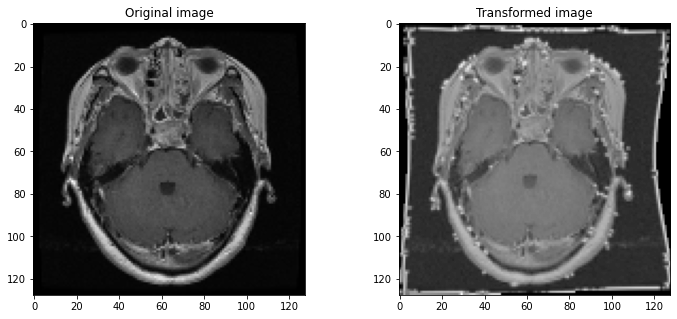

In [66]:
plt.figure(figsize = (12, 5))
img = cv2.imread(train_paths[random.randint(0, len(train_paths)-1)], 0)
plt.imshow(img, cmap='gray')
img = cv2.resize(img, (128, 128))
modifiedImg = transform_images(img)

plt.subplot(1,2,1)
plt.title("Original image")
plt.imshow(img, cmap='gray')

plt.subplot(1,2,2)
plt.title("Transformed image")
plt.imshow(modifiedImg, cmap='gray')

## Model

Our data generator is now ready to feed batches of data into a model. Let's design a model and pass it our training data.

In [ ]:
import torch
from torchvision import models

vgg16 = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/mohanad/.cache/torch/hub/checkpoints/vgg16-397923af.pth
4.4%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

12.5%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

20.9%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg

In [100]:
# Train model

for epoch in range(3):
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    
    for i, (images,labels) in enumerate(data_generator(train_paths)):
        optimizer.zero_grad()
        outputs=model(images)
        loss=criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        train_accuracy+=int(torch.sum(prediction==labels.data))
        
    train_accuracy=train_accuracy/len(train_paths)
    print(f"Training accuracy at epoch {epoch}: {train_accuracy}")

(10, 128, 128)


TypeError: conv2d() received an invalid combination of arguments - got (numpy.ndarray, Parameter, NoneType, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!numpy.ndarray!, !Parameter!, !NoneType!, !tuple!, !tuple!, !tuple!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!numpy.ndarray!, !Parameter!, !NoneType!, !tuple!, !tuple!, !tuple!, int)


In [94]:
for i, (images,labels) in enumerate(data_generator(train_paths)):
    

[2 0 2 2 3 0 2 1 1 1]


In [97]:
len(train_paths)

5712